### Imports

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm
from scipy.special import erf
import scipy.stats

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.core.modeling_framework import MultiCompartmentSphericalMeanModel
from dmipy.signal_models import sphere_models, cylinder_models, gaussian_models

from scipy.io import savemat

### Calculate ADC' (Prime)
#### I have a feeling this would be much more useful if it took arrays as inputs and outputted an array. But this current method is good for the list comprehension line. 

In [38]:
def calc_adc_prime(adc, sigma, axr, tm):
   adc_prime = adc * (1 - sigma* np.exp(-tm*axr))
   return adc_prime


### Simulate Signal

In [39]:
def simulate_sig(adc, sigma, axr, bf, be, tm, acq):
    """Generate an normalised output signal s based on known inputs for a given voxel
Inputs  - adc:      apparent diffusion coefficient [m2/s]
        - sigma:    filter efficiency
        - axr:      exchange rate [1/s]
        - bf:       filter block b-value [m2/s]
        - be:       encoding block b-value [m2/s]
        - tm:       mixing time [s]

Output: - s:        signal (sum of the magnetisations) single value
   Based off Elizabeth's code
    """

    if bf == 0 and tm[acq] == min(tm):
        tm[acq] = np.inf

    #calculate ADC as fnc of mixing time

    adc_prime = calc_adc_prime(adc,sigma,axr,tm[acq])

    #compute signal
    normalised_signal = np.exp(-adc_prime*be)

    return normalised_signal, adc_prime
    

### Initial variables.

In [40]:
nvox = 100 # number of voxels to simulate

bf = np.array([0, 0, 250, 250, 250, 250, 250, 250]) * 1e6   # filter b-values [s/m2]
be = np.array([0, 250, 0, 250, 0, 250, 0, 250]) * 1e6       # encoding b-values [s/m2]
tm = np.array([20, 20, 20, 20, 200, 200, 400, 400]) * 1e-3  # mixing time [s]
"""^also defined in neural net forward function. See if I can avoid duplicate. """

sim_adc = np.random.uniform(1e-9,1e-10,nvox)                # ADC, simulated [m2/s]
sim_sigma = np.random.uniform(0.1,0.9,nvox)                 # sigma, simulated [a.u.]
sim_axr = np.random.uniform(1,5,nvox)                       # AXR, simulated [s-1]

# simulate signals    
sigs_and_adc_prime = np.array([[simulate_sig(sim_adc[voxel], sim_sigma[voxel], sim_axr[voxel], bf[acq], be[acq], tm, acq) 
                    for acq in range(np.size(tm))] 
                    for voxel in range(nvox)])

signals = sigs_and_adc_prime[:, :, 0]
adc_prime = sigs_and_adc_prime[:, :, 1]

### Plotting b-value against normalised signal

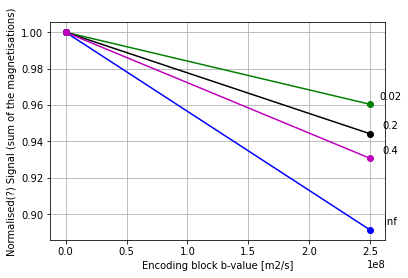

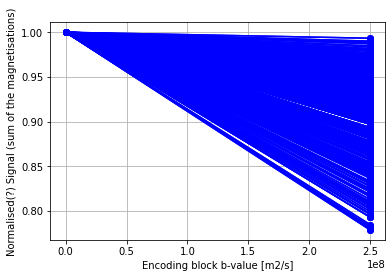

In [41]:
plt.plot([be[0], be[1]], [signals[0,0], signals[0,1]], 'bo-')
plt.annotate(tm[0], (be[1], signals[0, 1]), textcoords="offset points", xytext=(20,5), ha='center')

plt.plot([be[2], be[3]], [signals[0,2], signals[0,3]], 'go-')
plt.annotate(tm[2], (be[3], signals[0, 3]), textcoords="offset points", xytext=(20,5), ha='center')

plt.plot([be[4], be[5]], [signals[0,4], signals[0,5]], 'ko-')
plt.annotate(tm[4], (be[5], signals[0, 5]), textcoords="offset points", xytext=(20,5), ha='center')

plt.plot([be[6], be[7]], [signals[0,6], signals[0,7]], 'mo-')
plt.annotate(tm[6], (be[7], signals[0, 7]), textcoords="offset points", xytext=(20,5), ha='center')


#plt.title('Scatter plot with 4 lines')
plt.xlabel('Encoding block b-value [m2/s]')
#are units correct
plt.ylabel('Normalised(?) Signal (sum of the magnetisations)')
#unit?
plt.grid(True)
plt.show()

for a in range(signals.shape[0]):
    for i in range(be.shape[0] - 1):
        plt.plot([be[i], be[i + 1]], [signals[a,i], signals[a,i + 1]], 'bo-')



#plt.title('Scatter plot with 4 lines')
plt.xlabel('Encoding block b-value [m2/s]')
#are units correct
plt.ylabel('Normalised(?) Signal (sum of the magnetisations)')
#unit?
plt.grid(True)
plt.show()

### Creating the neural network

In [42]:
class Net(nn.Module): # this is the neural network
    #defining the init and foward pass functions. 

    def __init__(self,adc_prime,be,bf,tm,nparams):
        super(Net, self).__init__()

        self.adc_prime = adc_prime
        self.be = be
        self.bf = bf
        self.tm = tm

        """^Do I need to add adc_prime here?^ or to arguements of init?
        Yes, I think it is adc_prime, not signal. See my notes from 28/11 on remarkable.
        """

        #defining the layers that we want. 
        # 3 layers with no. of be nodes. 
        self.layers = nn.ModuleList()
        for i in range(3): # 3 fully connected hidden layers
            self.layers.extend([nn.Linear(len(be), len(be)), nn.PReLU()])
            #https://pytorch.org/docs/stable/generated/torch.nn.PReLU.html
        self.encoder = nn.Sequential(*self.layers, nn.Linear(len(be), nparams))

    def forward(self, X):
        """
        What is X? snigdha's repo may help 
        Very unconfident in this as is rn.
        """

        params = torch.nn.functional.softplus(self.encoder(X))
        """ ^unclear of purpose or if needed"""
        #SoftPlus is a smooth approximation to the ReLU function and can be used to constrain the output of a machine to always be positive


        #params seems be a table containing each variable in a new column. 
        #unsqueeze adds an additional dimension. 
        #parameter constraints from Elizabeth matlab 
        adc = torch.clamp(params[:,0].unsqueeze(1), min=.1e-9, max=3.5e-9) 
        sigma = torch.clamp(params[:,1].unsqueeze(1), min=0, max=1)
        axr = torch.clamp(params[:,2].unsqueeze(1), min=.1, max=20)

        tm = np.array([20, 20, 20, 20, 200, 200, 400, 400]) * 1e-3  # mixing time [s]
        adc_prime = calc_adc_prime(adc,sigma,axr,tm)
        
        X = adc_prime

        return X, adc, sigma, axr


### NN continued

In [43]:
# define network
nparams = 4

#initilise network
net = Net(adc_prime, be, bf, tm, nparams)

#create batch queues for data
batch_size = 128
#// means divide and round down. 
num_batches = len(nvox) // batch_size
'''Unclear if nvox is correct.'''

#import the E_vox array into the dataloader amd convert to float.
#drop_last ignores the last batch if it is the wrong size. 
#num_workers is about performance. 
'''Unclear what to use instead of E_vox. Maybe adc_prime.'''

trainloader = utils.DataLoader(torch.from_numpy(E_vox.astype(np.float32)),
                                batch_size = batch_size, 
                                shuffle = True,
                                num_workers = 0, #was 2 previously
                                drop_last = True)

# loss function and optimizer
#choosing which loss function to use. 
#not sure what the optmizer is
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

# best loss
best = 1e16
num_bad_epochs = 0
#can increase patience a lot, speed not an issue.
patience = 10

TypeError: object of type 'int' has no len()

### Training

In [ ]:
"""Unchanged and untouch from snighda
Have not made changes. 
"""
# train
for epoch in range(10000): 
    print("-----------------------------------------------------------------")
    print("epoch: {}; bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    #tqdm shows a progress bar. 
    for i, X_batch in enumerate(tqdm(trainloader), 0):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        X_pred, f_ic_pred, f_ees_pred, r_pred, d_ees_pred = net(X_batch)
        loss = criterion(X_pred, X_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
      
    print("loss: {}".format(running_loss))
    # early stopping
    if running_loss < best:
        print("####################### saving good model #######################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("done, best loss: {}".format(best))
            break
print("done")

net.load_state_dict(final_model)

net.eval()
with torch.no_grad():
    X_real_pred, f_ic, f_ees, r, d_ees = net(torch.from_numpy(E_vox.astype(np.float32)))

f_vasc = 1 - f_ic - f_ees

f_vasc = f_vasc/(f_ic + f_ees + f_vasc)
A = f_vasc
normA = A - min(A)
f_vasc = 0.2 * (normA/max(normA))
f_ic = f_ic/(f_ic + f_ees + f_vasc)
f_ees = f_ees/(f_ic + f_ees + f_vasc)
